In [52]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.special import logsumexp
import itertools
from tqdm import tqdm



def load_data(file_name, data_path='data/'):
    return pd.read_csv(data_path + file_name + '.csv', index_col=0).values


def accuracy(true, pred):
    return np.mean(true == pred)


def plot_barplot(a, b, labels, xlabel=None, ylabel=None, title=None, figname=None, ylim=(0,1.1)):
    fig, ax = plt.subplots(1, 1)
    temp = pd.DataFrame([a, b], columns=np.arange(len(a)), index=labels).T
    temp.plot.bar(rot=0, width=.5, ax=ax)
    ax.set_ylim(ylim)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    fig.tight_layout()
    plt.savefig(f'plots/{figname}.png')
    plt.show()


def plot_with_errorbars(data, x_ticks, ax, label=None, title=None, xlabel=None, ylabel=None,
                        ylims=None, c='black'):
    mean_data = data.mean(axis=0)
    std_data = data.std(axis=0)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.plot(x_ticks, mean_data, label=label, c=c, marker='o')
    ax.errorbar(x_ticks, mean_data, std_data, c=c,
                capsize=3, capthick=1)
    if ylims is not None: ax.set_ylim(ylims)
    return ax


def plot_posterior_vs_M(est_posteriors, exact_posteriors, algo_name, M_arr, t=5, x=1):
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))
    for i in range(10):
        axs.flat[i].plot(M_arr, [exact_posteriors[i, t, x]] * len(M_arr), label='Exact', c='tab:orange', marker='o')
        plot_with_errorbars(est_posteriors[:, :, i, t, x], x_ticks=M_arr, ax=axs.flat[i],
                            label=algo_name, title=f'obs[{i}]',
                            xlabel='M', ylabel=f'posterior - p(X{t}={x} | obs[{i}])',
                            ylims=(-0.1, 1.1))
    axs.flat[0].legend()
    fig.suptitle(f'{algo_name} vs Exact posterior for t={t}')
    fig.tight_layout()
    plt.savefig(f'plots/{algo_name}_est_vs_exact_posterior.png')
    plt.show()


Load HMM. CPDs:
prior
['prior(0)=0.100' 'prior(1)=0.900']
transition_mat
[['tau(0->0)=0.100' 'tau(0->1)=0.900']
 ['tau(1->0)=0.200' 'tau(1->1)=0.800']]
emission_mat
[['e(0->0)=0.800' 'e(0->1)=0.200']
 ['e(1->0)=0.100' 'e(1->1)=0.900']]



    ########################################
    ##########         Q1         ##########
    ########################################



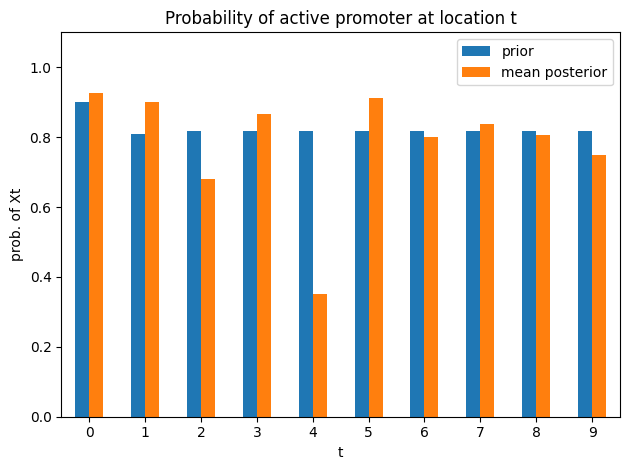


    ########################################
    ##########        Q2-3        ##########
    ########################################



In [87]:
np.seterr(divide='ignore')


def assert_dist_non_negative(log_p):
    assert np.all(log_p <= 0)


def assert_dist_sums_to_1(log_p, axis, check_idx=None):
    if check_idx is None: assert np.all(np.isclose(np.exp(logsumexp(log_p, axis=axis)), 1))
    else: assert np.all(np.isclose(np.exp(logsumexp(log_p, axis=axis)[check_idx]), 1))


def _log_forward(data_obs, log_p, log_t_mat, log_e_mat, val_X, T):
    """
    F[1, k] = p(X_1 = k, o_1) = p(o_1 | X_1 = k) * p(X_1 = k) = e[k -> o_1] * p[k]
    F[t, k] = p(X_t = k, o_{1:t}) = e[k -> o_t] * sum_l[ F[t-1, l] * tau[l -> k] ]
    shape = N x T x |Val(X)|
    """
    N = data_obs.shape[0]
    log_F = np.zeros((N, T, len(val_X))) - np.inf
    log_F[:, 0] = log_p + log_e_mat[:, data_obs[:, 0]].T
    for t in range(1, T):
        temp = log_F[:, t - 1, None] + log_t_mat.T[None, :]
        log_F[:, t] = logsumexp(temp + log_e_mat[:, data_obs[:, t]].T[:, :, None], axis=2)

    # tests
    assert_dist_non_negative(log_F)
    return log_F


def _log_backward(data_obs, log_t_mat, log_e_mat, val_X, T):
    """
    B[T, k] = p(empty_set | X_T = k) = 1
    B[t, k] = p(o_{t+1:T} | X_t = k) = sum_s[ tau[k -> s] * B[t+1, s] * e[s -> o_{t+1}]]
    shape = N x T x |Val(X)|
    """
    N = data_obs.shape[0]
    log_B = np.zeros((N, T, len(val_X)))
    log_B[:, -1] = np.log(1)
    for t in np.arange(T - 1, 0, -1):
        temp = log_B[:, t, None] + log_t_mat[None, :]
        log_B[:, t - 1] = logsumexp(temp + log_e_mat[:, data_obs[:, t]].T[:, None, :], axis=2)

    # tests
    assert_dist_non_negative(log_B)
    return log_B


class HMM:
    def __init__(self, T, val_X, val_O, prior, transition_mat, emission_mat):
        self.T = T
        self.val_X = val_X
        self.val_O = val_O
        self.log_prior = np.log(prior)
        self.log_transition_mat = np.log(transition_mat)
        self.log_emission_mat = np.log(emission_mat)

    def get_CPDs(self):
        return {'prior': np.exp(self.log_prior),
                'transition_mat': np.exp(self.log_transition_mat),
                'emission_mat': np.exp(self.log_emission_mat)}

    def print_CPDs(self):
        cpds = self.get_CPDs()
        k = 'prior'
        print(k)
        print(np.array([f'prior({x})={cpds[k][x]:.3f}' for x in self.val_X]))
        k = 'transition_mat'
        print(k)
        print(np.array([[f'tau({xt}->{xtp1})={cpds[k][xt][xtp1]:.3f}' for xt in self.val_X] for xtp1 in self.val_X]).T)
        k = 'emission_mat'
        print(k)
        print(np.array([[f'e({xt}->{ot})={cpds[k][xt][ot]:.3f}' for ot in self.val_O] for xt in self.val_X]))

    ########################################
    ##########      Sampling      ##########
    ########################################
    def sample(self, N=1):
        """
        Assumes that the HMM CPDs are defined.
        :param N: optional, default=1. Number of samples.
        :return: (hidden, obs) for N samples from the HMM. shape of hidden & obs = (N,hmm.T)
        """
        cpds = self.get_CPDs()

        hidden_samples = np.zeros((N, self.T), dtype=int)
        obs_samples = np.zeros((N, self.T), dtype=int)

        for n in range(N):
            hidden_samples[n, 0] = np.random.choice(self.val_X, p=cpds['prior'])
            obs_samples[n, 0] = np.random.choice(self.val_O, p=cpds['emission_mat'][hidden_samples[n, 0]])

            for t in range(1, self.T):
                hidden_samples[n, t] = np.random.choice(self.val_X, p=cpds['transition_mat'][hidden_samples[n, t - 1]])
                obs_samples[n, t] = np.random.choice(self.val_O, p=cpds['emission_mat'][hidden_samples[n, t]])

        return (hidden_samples, obs_samples)

    ########################################
    ##########     Calc Prob.     ##########
    ########################################
    def log_joint(self, hidden, obs):
        """
        :param hidden - N hidden sequences. shape = (N,T)
        :param obs - N observations. shape = (N,T)
        :return log-joint probability. shape = (N)

        c3 = log(p1 * p2) = log(p1) + log(p2) = c1 + c2
        """
        N, T = hidden.shape
        log_p = self.log_prior[hidden[:, 0]] + self.log_emission_mat[hidden[:, 0], obs[:, 0]]

        for t in range(1, T):
            log_p += self.log_transition_mat[hidden[:, t - 1], hidden[:, t]] + self.log_emission_mat[
                hidden[:, t], obs[:, t]]

        return log_p

    def naive_log_likelihood(self, obs):
        """
        Calculate the log likelihood of the observations for each sample p(o1:T[i]) in a naive way (going over all
        possibilities). This will take many resources for T>5.
        :param obs - N observations. shape = (N,T)
        :return log-likelihood. shape = (N)
        """
        assert self.T < 6
        X = set(itertools.permutations(np.array([[x] * self.T for x in self.val_X]).flatten(), self.T))
        p = []
        for x in X:
            p.append(self.log_joint(np.broadcast_to(x, obs.shape), obs))
        return logsumexp(p, axis=0)


    def log_likelihood(self, obs):
        """
        :param obs - N observations. shape = (N,T)
        :return log-likelihood. shape = (N)

        log(p(o_[1:T]) = log (    sum_{k in Val(X)} p(o_1, ... , o_T, k) )     )
                       = log( sum_{k in Val(X)} exp ( log_p(o_1, ... , o_T, k) ) )
                       = log( sum_{k in Val(X)} exp ( F[T,k] )    )
        """
        log_forward = _log_forward(obs, self.log_prior, self.log_transition_mat, self.log_emission_mat, self.val_X,
                                   self.T)
        return logsumexp(log_forward[:, self.T - 1, :], axis=1)

    def log_prior_Xt(self):
        """
        :return point-wise prior. shape = (T, |val(X)|)
        P'[t, k] = p(X_t = k) = sum_{l in Val(x)} p(X_t = k | X_{t-1}=l) * p(X_{t-1} = l)
                             = sum_{l in Val(x)} P(X_t = k | X_{t-1}=l) * P'[t-1, l]
                             = P(X_t = k | X_{t-1}=l_1) * P'[t-1, l_1] + ...  P(X_t = k | X_{t-1}=l_n) * P'[t-1, l_n]

        P[t, k] = logp(X_t = k) = logp( exp(   logp(X_t = k | X_{t-1}=l_1) + P[t, l_1])   ) + ... + exp(   logp(X_t = k | X_{t-1}=l_n) + P[t, l_n])   ) )
        """
        val_X_len = len(self.val_X)
        log_p_Xt = np.full((self.T, val_X_len), -np.inf)
        log_p_Xt[0] = self.log_prior
        for t in range(1, self.T):
            for val_X_index in range(val_X_len):
                log_p_Xt[t, val_X_index] = logsumexp(self.log_transition_mat[:, val_X_index] + log_p_Xt[t - 1, :])

        # tests
        assert_dist_non_negative(log_p_Xt)  # p(Xt = k) >= 0
        assert_dist_sums_to_1(log_p_Xt, axis=-1)  # sum_k[ p(Xt = k) ] == 1
        return log_p_Xt

    def log_naive_posterior_Xt(self, obs):
        """
        :param obs - N observations. shape = (N,T)
        :return point-wise posterior. shape = (N, T, |val(X)|)

        log( p(X_t = x_t | O_t = o_t) ) = log(     p(X_t = x_t) * p(O_t = o_t | X_t = x_t)    /    sum_{x in Val(X)}  p(X_t = x) * p(O_t = o_t | X_t = x)  )
                                      = log_p(X_t = x) + log_p(O = o_t| X = x) - log(sum_{x in Val(X)}  p(X_t = x) * p(O = o_t | X = x)  )
                                      = log_p(X_t = x) + log_p(O = o_t| X = x) - log(sum_{x in Val(X)}  exp( log_p(X_t = x) + log_p(O = o_t | X = x)  )

        """
        N = len(obs)
        val_X_len = len(self.val_X)

        log_prior_Xt = self.log_prior_Xt()
        log_posterior_Xt_given_Ot = np.full((N, self.T, val_X_len), -np.inf)

        for n in range(N):
            for t in range(self.T):
                log_p_Xt = log_prior_Xt[t]
                log_p_O_given_X = self.log_emission_mat[:, obs[n, t]]
                log_posterior_Xt_given_Ot[n, t, :] = log_p_Xt + log_p_O_given_X - logsumexp(log_p_Xt + log_p_O_given_X)

        # tests
        assert_dist_non_negative(log_posterior_Xt_given_Ot)  # p(Xt = k | ot) >= 0
        assert_dist_sums_to_1(log_posterior_Xt_given_Ot, axis=-1)  # sum_k[ p(Xt = k | ot) ] == 1
        return log_posterior_Xt_given_Ot

    def log_posterior_Xt(self, obs):
        """
        TODO(Proj2) Calculate the posterior p(X_t=x | o=obs[i])
        :param obs - N observations. shape = (N,T)
        :return log posterior for Xt. shape = (N, T, |val(X)|)
        """
        log_post_Xt = np.zeros((len(obs), self.T,  len(self.val_X))) # N X T X |Val(X)|
        
        log_likelihood = self.log_likelihood(obs) # N
        log_forward = _log_forward(obs, self.log_prior, self.log_transition_mat, self.log_emission_mat, self.val_X, self.T) # N x T x |Val(X)|
        log_backward = _log_backward(obs, self.log_transition_mat, self.log_emission_mat, self.val_X, self.T) # N x T x |Val(X)|
        
        # log_post_Xt(i, t, k) = log_forward(i, t, k) + log_backward(i,t,k) - log_likelihood(i)
        log_post_Xt = log_forward + log_backward - log_likelihood[:, np.newaxis, np.newaxis]
        
        assert_dist_sums_to_1(log_post_Xt, axis=2)  # sum_k[ p(Xt = k | o) ] == 1
        
        return log_post_Xt

    ########################################
    ##########     Est. Prob.     ##########
    ########################################
    
        
    
    def gibbs_sampling_posterior(self, obs, M_max=100, M_start=50):
        """
        For each observation obs[i]:
                1. Sample a starting point X1
                2. Sample Xt given the others and given obs[i] for M iterations
                3. Use the last M-M_start samples to estimate the probability of each Xt given obs p(Xt | o=obs[i])
        Note: you can sample for all N observations simultaneously

        :param obs - N observations. shape = (N,T)
        :param M_max: number of iterations to use for Gibbs (int)
        :return: estimated log posterior for Xt. shape = (N, T, |val(X)|)
        """
        
        N = len(obs)
        val_X_len = len(self.val_X)

        # Initialize samples
        samples = np.zeros((M_max, N, self.T), dtype=int)
        
        samples[0, :, :] = np.random.choice(self.val_X, size=(N, self.T))

        for m in range(1, M_max):
            samples[m, :, :] = samples[m - 1, :, :]

            for t in range(self.T):
                # Calculate conditional distribution for current position for all samples
                log_prob = self.log_emission_mat[:, obs[:, t]].T

                if t > 0:
                    log_prob += self.log_transition_mat[:, samples[m, :, t - 1]].T
                if t < self.T - 1:
                    log_prob += self.log_transition_mat[:, samples[m, :, t + 1]].T

                log_prob -= logsumexp(log_prob, axis=1, keepdims=True)
                
                samples_t = [np.random.choice(self.val_X, p=np.exp(log_prob[i])) for i in range(N)]
                
                samples[m, :, t] = samples_t
                    

        # Use samples from M_start to M_max to estimate the posterior
        post_samples = samples[M_start:M_max]
        log_post_Xt = np.zeros((N, self.T, val_X_len))

        for i in range(N):
            for t in range(self.T):
                for k in range(val_X_len):
                    log_post_Xt[i, t, k] = np.sum(post_samples[:, i, t] == k)

        log_post_Xt = np.log(log_post_Xt / (M_max - M_start))

        # Ensure the distribution sums to 1
        assert_dist_sums_to_1(log_post_Xt, axis=2)
        
        return log_post_Xt
    

    def likelihood_weighting_posterior(self, obs, M_max=100):
        """
        TODO(Proj2) For each observation obs[i]:
                1. Sample M_max samples from the network
                2. Calculate their LW weights
                3. Use LW to estimate the probability of each Xt given obs p(Xt | o=obs[i])
        Note: you can sample and calculate the weights of all N*M_max samples simultaneously

        :param obs - N observations. shape = (N,T)
        :param M_max: number of samples to use for LW (int)
        :return: estimated log posterior for Xt. shape = (N, T, |val(X)|)
        """
        log_post_Xt = None
        assert_dist_sums_to_1(log_post_Xt, axis=2)  # sum_k[ p(Xt = k | o) ] == 1
        return log_post_Xt

    ########################################
    ##########     Prediction     ##########
    ########################################
    def naive_predict_by_naive_posterior(self, obs):
        """
        TODO predict a sequence of hidden states for each sample using the point-wise posterior:
            X_hat[i][t] = argmax_x[ p(X_t=x | ot=obs[i][t]) ]
        :param obs - N observations. shape = (N,T)
        :return X_hat - N hidden sequences. shape = (N,T)
        """
        X_hat = np.argmax(self.log_naive_posterior_Xt(obs), axis=-1)
        return X_hat

    def naive_predict_by_posterior(self, obs, log_post_Xt=None):
        """
        TODO(Proj2) predict a sequence of hidden states for each sample using the posterior:
            X_hat[i][t] = argmax_x[ p(X_t=x | o=obs[i]) ]
        :param obs - N observations. shape = (N,T)
        :param log_post_Xt - optional. Use it to predict the hidden states. If not given, calculate using
                                        the log_posterior_Xt method. shape = (N, T, |val(X)|)
        :return X_hat - N hidden sequences. shape = (N,T)
        """
        if log_post_Xt is None:
            log_post_Xt = self.log_posterior_Xt(obs)
            
        return np.argmax(log_post_Xt, axis=-1)
        



def get_hmm():
    # define HMM
    val_X = np.arange(2)
    val_O = np.arange(2)
    hmm_params = {
        'prior': np.array([0.1, 0.9]),
        'transition_mat': np.array([[0.1, 0.9],  # p(X_{t+1}=x | X_t=0)
                                    [0.2, 0.8]]),  # p(X_{t+1}=x | X_t=1)
        'emission_mat': np.array([[0.8, 0.2],
                                  [0.1, 0.9]])
    }
    T = 10

    hmm = HMM(T=T, val_X=val_X, val_O=val_O, prior=hmm_params['prior'],
              transition_mat=hmm_params['transition_mat'], emission_mat=hmm_params['emission_mat'])
    print(f'Load HMM. CPDs:')
    hmm.print_CPDs()
    print()
    print()
    return hmm


########################################
##########         Q1         ##########
########################################

def Q1_prior_vs_posterior(hmm, obs):
    """
    1. Calculate the posterior p(Xt | obs[i]) for each obs i
    2. Plot the prior vs the mean posterior of Xt=1 (mean over the observations i=1,...,N)

    TODO: You need to implement the log_posterior_Xt method in the HMM class

    :param obs - N observations. shape = (N,T)
    """
    # Calculate the prior p(Xt = 1)
    priors = np.exp(hmm.log_prior_Xt())[:, 1]
    # Calculate the posterior p(Xt | obs[i]) for each obs i
    log_post_Xt = hmm.log_posterior_Xt(obs)
    mean_posteriors = np.exp(log_post_Xt).mean(axis=0)[:, 1]  # mean over observations i of p(Xt=1 | obs[i])

    # Plot the prior vs the mean posterior (mean over the observations i=1,...,N)
    plot_barplot(priors, mean_posteriors, labels=['prior', 'mean posterior'], xlabel='t', ylabel='prob. of Xt',
                 title='Probability of active promoter at location t', figname='q1_prior_vs_mean_posterior')
    return log_post_Xt


def Q1_predictions(hmm, hidden, obs):
    """
    1. Predict the hidden assignment for each observation using the rule:
                    X_hat[i][t] = argmax_x[ p(X_t=x | o=obs[i]) ]
    2. Calculate the accuracy of the predication

    TODO: You need to implement the naive_predict_by_posterior method in the HMM class

    :param hidden - N hidden sequences. shape = (N,T)
    :param obs - N observations. shape = (N,T)
    """
    # Predict the hidden assignment for each observation using the rule:
    #                     X_hat[i][t] = argmax_x[ p(X_t=x | o=obs[i]) ]
    pred = hmm.naive_predict_by_posterior(obs)
    # Calculate the accuracy of the predication
    res = accuracy(pred, hidden)
    print(f'Accuracy for exact posterior = {res:.3f}')


########################################
##########        Q2-3        ##########
########################################

def calc_posterior_for_M_arr(obs, hmm, M_arr, n_repeats, algo_name):
    log_post_Xt_est = [[] for k in range(n_repeats)]
    for k in tqdm(range(n_repeats)):
        for M in M_arr:
            # if algo_name == 'RS': log_post_Xt_est[k].append(hmm.rejection_sampling_posterior(obs, M))
            if algo_name == 'Gibbs': log_post_Xt_est[k].append(hmm.gibbs_sampling_posterior(obs, M, M_start=M // 2))
            elif algo_name == 'LW': log_post_Xt_est[k].append(hmm.likelihood_weighting_posterior(obs, M))

    return log_post_Xt_est


def Q23(obs, hmm, exact_log_post_Xt, M_arr, n_repeats, algo_name):
    """
    1. Estimates the log posterior of Xt using 'algo_name' (Gibbs or LW) with M samples for each M in M_arr.
    2. Repeated n_repeats times
    3. Plot the posterior vs M

    TODO: You need to implement the gibbs_sampling_posterior and likelihood_weighting_posterior methods in the HMM class
    """
    est_log_post_Xt = calc_posterior_for_M_arr(obs, hmm, M_arr, n_repeats, algo_name)
    plot_posterior_vs_M(np.exp(est_log_post_Xt), np.exp(exact_log_post_Xt), algo_name, M_arr, t=5, x=1)
    return est_log_post_Xt


########################################
##########         Q4         ##########
########################################
def Q4_predictions(hmm, est_log_post_Xt_per_algo, exact_log_post_Xt, hidden, M_arr, n_repeats=5):
    """
    1. Predict the hidden sequence for each sample using the est_log_post_Xt_per_algo (for each algo) and using
            the exact posteriors
    3. Plot the accuracy vs M

    TODO: You need to implement the naive_predict_by_posterior methods in the HMM class
    """
    fig, ax = plt.subplots(1, 1)

    c = 0
    for algo_name, est_log_post_Xt in est_log_post_Xt_per_algo.items():
        # calculate accuracies for estimated posteriors
        res = []
        for M_, M in enumerate(M_arr):
            res.append([])
            for k in range(n_repeats):
                pred = hmm.naive_predict_by_posterior(obs, log_post_Xt=est_log_post_Xt[k][M_])
                res[M_].append(accuracy(hidden, pred))
        res = np.array(res)
        # print
        print(f'Accuracies for {algo_name}:')
        for M_, M in enumerate(M_arr): print(f'M={M}:\t{res[M_].mean():.2f} ± {res[M_].std():.3f}')
        # plot
        plot_with_errorbars(res.T, M_arr, ax, label=algo_name, c=plt.colormaps["Set1"](c),
                            title='Prediction using estimated posteriors', xlabel='M', ylabel='Accuracy')
        c += 1

    # calculate accuracies for exact posteriors
    pred = hmm.naive_predict_by_posterior(obs, log_post_Xt=exact_log_post_Xt)
    res = accuracy(hidden, pred)
    # print
    print(f'Accuracy for Exact Inference:', res)
    # plot
    ax.plot(M_arr, [res] * len(M_arr), label=f'Exact', marker='o', c='black')
    ax.legend()
    fig.tight_layout()
    plt.savefig(f'plots/est_vs_exact_accuracy.png')
    plt.show()






# if __name__ == '__main__':
# Load HMM
hmm1 = get_hmm()


# Load observations
hidden = load_data('hidden_data')
obs = load_data('obs_data')




# Q1
print('''
    ########################################
    ##########         Q1         ##########
    ########################################
''')

exact_log_post_Xt = Q1_prior_vs_posterior(hmm1, obs)



# Q2, Q3
print('''
    ########################################
    ##########        Q2-3        ##########
    ########################################
''')



In [83]:
from sklearn.metrics import confusion_matrix

Q1_predictions(hmm1, hidden, obs)


# Q5 from exercise 1
def q5_test_pred(hmm, data_obs, data_hidden, val_X):
    X_hat = hmm.naive_predict_by_naive_posterior(data_obs)
    print(f'Naive prediction accuracy = {accuracy(data_hidden.flatten(), X_hat.flatten())}')
    
q5_test_pred(hmm1, obs, hidden, hmm1.val_X)

Accuracy for exact posterior = 0.900
Naive prediction accuracy = 0.895



    ########################################
    ##########        Q2-3        ##########
    ########################################



100%|██████████| 5/5 [00:16<00:00,  3.37s/it]


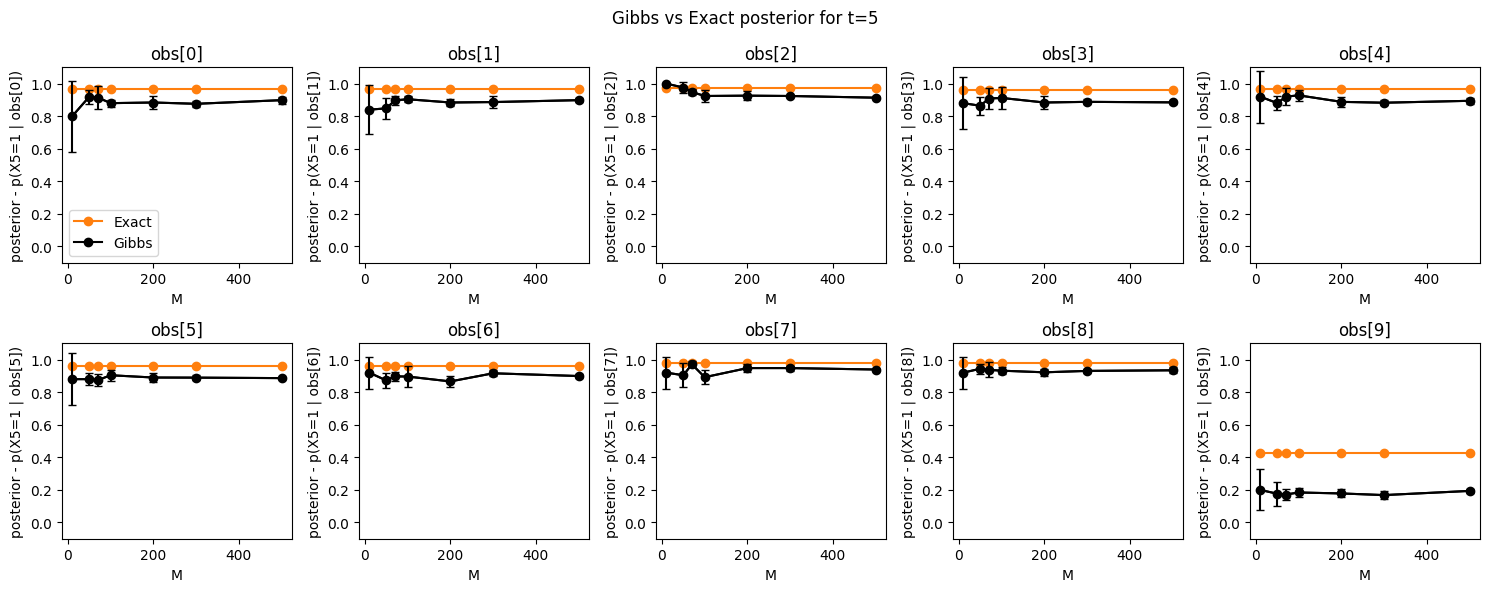

In [88]:

# Q2, Q3
print('''
    ########################################
    ##########        Q2-3        ##########
    ########################################
''')
M_arr = [10, 50, 70, 100, 200, 300, 500]
n_repeats = 5
est_log_post_Xt_per_algo = {}
for algo_name in ['Gibbs']: #, 'LW']:  # TODO: If you choose to not implement the bonus 'LW', remove it from this list.
    est_log_post_Xt_per_algo[algo_name] = Q23(obs, hmm1, exact_log_post_Xt, M_arr, n_repeats, algo_name)




# # Q4
# print('''
#     ########################################
#     ##########         Q4         ##########
#     ########################################
# ''')
# Q4_predictions(hmm1, est_log_post_Xt_per_algo, exact_log_post_Xt, hidden, M_arr, n_repeats=n_repeats)



Differences between Prior and Posterior Distributions

	1.	Variability:
	•	The prior distribution (blue bars) shows less variability across different time steps  t . This indicates that the initial belief about the probability of an active promoter being at each location  t  was relatively uniform or had little variance.
	•	The mean posterior distribution (orange bars) exhibits more variability, indicating that the observed data has influenced the belief about the probability of an active promoter being at each location.
	2.	Adjustments due to Observations:
	•	At some locations (e.g.,  t = 0  and  t = 9 ), the mean posterior probabilities are significantly higher than the prior probabilities, indicating that the observations strongly suggest the presence of an active promoter at these locations.
	•	Conversely, at  t = 4 , the posterior probability is much lower than the prior, suggesting that the observations provide evidence against an active promoter at this location.

Implications on the Distribution of Observations

	•	Inference from Data:
	•	The posterior distributions are adjusted based on the observed data, which implies that the observations have provided significant information about the presence of active promoters at different locations. The mean posterior being different from the prior shows that the data has been informative and has changed the initial beliefs.
	•	Predictive Insights:
	•	The changes from the prior to the posterior indicate how the model updates its predictions based on the new data. For instance, the high posterior probabilities at certain  t  suggest that the model has found strong evidence in the observations supporting an active promoter at these locations.
	•	Sampling Distribution:
	•	The variability in the posterior probabilities suggests that the observations come from a distribution with varying promoter activities across different locations. This variation hints at a non-uniform distribution of active promoters in the underlying process that generated the observations.

In summary, the differences between the prior and posterior distributions highlight the impact of the observed data on updating beliefs about active promoters at different locations. The variability and adjustments seen in the posterior distribution indicate that the observations have provided substantial information, leading to a refined understanding of promoter activity across the locations. This suggests that the underlying distribution from which the observations were sampled has heterogeneity in promoter activities.


Based on the results provided in the attached images:

	•	Exact Posterior Prediction Accuracy: 0.900
	•	Naive Prediction Accuracy: 0.895

Analysis

	1.	Accuracy Comparison:
	•	The exact posterior prediction accuracy (0.900) is slightly higher than the naive prediction accuracy (0.895). This suggests that using the exact posterior method provides a marginally better prediction of the hidden states compared to the naive method.
	2.	Differences in Methods:
	•	The exact posterior method incorporates the forward-backward algorithm, which uses the entire sequence of observations to infer the hidden states. This method considers the full context of the sequence, resulting in a more accurate prediction.
	•	The naive prediction method, as implied by its name, likely uses a simpler approach such as the maximum likelihood estimate for each individual observation without considering the sequence context. This can lead to slightly less accurate predictions because it ignores temporal dependencies.
	3.	Implications of Results:
	•	The small difference in accuracy indicates that while both methods are reasonably effective, the exact posterior method is better at capturing the dependencies and patterns in the data.
	•	The rule in Eq. 4 (using the exact posterior) is a good prediction rule because it leverages the entire observation sequence, leading to a more informed prediction of the hidden states.
	•	The slightly lower accuracy of the naive method suggests that it can be a reasonable approximation in some cases, but it may miss out on important temporal information that can be captured by the exact posterior method.

Conclusion

The exact posterior prediction rule (Eq. 4) is validated by the slightly higher accuracy compared to the naive prediction method. The use of the full sequence of observations in the exact posterior method leads to better performance and more accurate predictions of hidden states, making it a preferable choice for predicting segmentations to active promoters given a sequence of modifications.